In [1]:
%gui qt

import numpy as np
import matplotlib as mpl
import scipy.signal as signal
from vispy import scene
from PyQt5.QtWidgets import QWidget, QVBoxLayout, QPushButton
from PyQt5.QtCore import QTimer

class LineView(scene.SceneCanvas):
    def __init__(self):
        super().__init__(keys=None)
        self.unfreeze()
        self.grid = self.central_widget.add_grid(margin=10)
        self.view = self.grid.add_view(row=0, col=1)
        self.view.camera = 'panzoom'
        self.lines = []
        self.colors = mpl.colormaps.get_cmap('Set3')
        self._setup_axes()
        self.freeze()

    def set_data(self, positions, width=2, colors=None):
        """Set line data and update view.
        
        Parameters
        ----------
        positions : array-like or list of array-like
            Position data for the line(s). Can be:
            - A single array of shape (N,) for 1D data
            - A single array of shape (N, 2) for 2D data 
            - A list of arrays for multiple lines
        width : float, optional
            Line width in pixels. Default is 1.
        colors : array-like or list of array-like, optional
            Colors for the line(s). Can be:
            - A single RGB/RGBA tuple for a single line
            - A list of RGB/RGBA tuples for multiple lines
            If None, defaults to white (1,1,1,1).
        """
        self.clear()
        
        if not isinstance(positions, list):
            positions = [positions]
            colors = [colors if colors else (1,1,1,1)]
            
        if colors is None:
            colors = [self.colors(i) for i in range(len(positions))]

        for pos, color in zip(positions, colors):
            pos = np.column_stack((np.arange(len(pos)), pos)) if pos.ndim == 1 else pos
            self.lines.append(scene.visuals.Line(pos=pos, color=color, 
                                               width=width, parent=self.view.scene))
        
        self.view.camera.set_range()

    def _setup_axes(self, color=(1, 1, 1, 0.8)):
        axis_props = dict(text_color=color, axis_color=color, tick_color=color)
        self.xaxis = scene.AxisWidget(orientation='bottom', **axis_props)
        self.yaxis = scene.AxisWidget(orientation='left', **axis_props)
        
        self.xaxis.stretch = (0.9, 0.1)
        self.yaxis.stretch = (0.1, 0.9)
        
        self.grid.add_widget(self.xaxis, row=1, col=1)
        self.grid.add_widget(self.yaxis, row=0, col=0)
        self.xaxis.link_view(self.view)
        self.yaxis.link_view(self.view)

    def clear(self):
        for line in self.lines:
            line.parent = None
        self.lines.clear()


class FrView(LineView):
    def __init__(self, bin_size=5.0, sigma=3.0):
        super().__init__()
        self.unfreeze()
        self.bin_size = bin_size
        if sigma is None:
            self.window = None
        else:
            self.window = signal.windows.gaussian(sigma*6, sigma)
            self.window /= self.window.sum()
        self.freeze()
    
    def set_data(self, data):
        x = np.arange(len(data)) * (self.bin_size / 60)
        y = (np.convolve(
            np.pad(data, len(self.window)//2, mode='reflect'),
            self.window,
            mode='valid'
        )[:len(data)] if self.window is not None else data)
        super().set_data(np.column_stack((x, y)))


class FrGUI(QWidget):
    def __init__(self):
        super().__init__()
        self.timer = QTimer()
        self.timer.timeout.connect(self.set_data)
        self.plot = FrView()
        
        self.start_btn = QPushButton('Start')
        self.start_btn.setCheckable(True)
        self.start_btn.clicked.connect(self._toggle_timer)
        
        layout = QVBoxLayout()
        layout.addWidget(self.start_btn)
        layout.addWidget(self.plot.native)
        self.setLayout(layout)

    def _toggle_timer(self, checked):
        self.timer.start(1000) if checked else self.timer.stop()
    
    def set_data(self):
        self.plot.set_data(np.random.randint(2, 10, 360))

    def closeEvent(self, event):
        self.timer.stop()
        super().closeEvent(event)

gui = FrGUI()
gui.show()

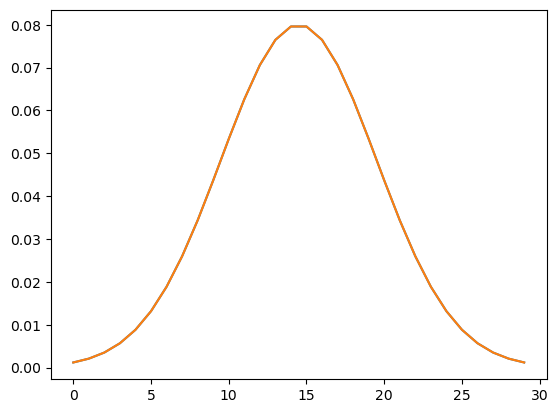

In [2]:
# test gaussian
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

sigma = 5
n = 6*sigma
win = signal.windows.gaussian(n, sigma)
win = win / win.sum()

# manually calculate gaussian
n = np.arange(n) - (n - 1.0) / 2.0
sig2 = 2 * sigma * sigma
w = np.exp(-n ** 2 / sig2)

y = w / w.sum()
plt.plot(win)
plt.plot(y)

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(str(os.path.join(os.path.abspath('..'))))

from nctrl.view import LineView
from nctrl.view import FrGUI

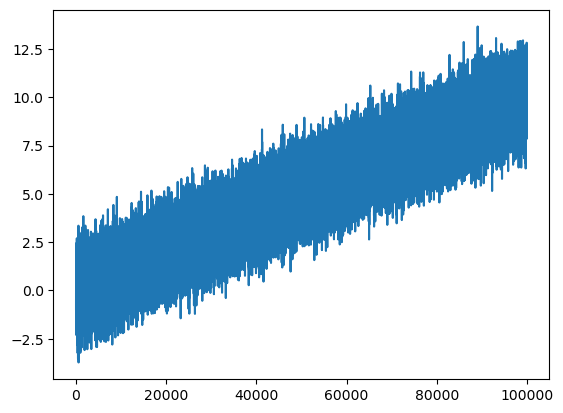

In [4]:
pos_x = np.arange(100000)
pos_y = np.random.randn(100000) + 0.0001 * pos_x

plt.plot(pos_x, pos_y)

In [5]:
from PyQt5.QtWidgets import QWidget, QVBoxLayout

class TestGUI(QWidget):
    def __init__(self):
        super().__init__()
        self.plot = LineView()
        self.setLayout(QVBoxLayout())
        self.layout().addWidget(self.plot.native)

    def set_data(self, data):
        self.plot.set_data([data])


window = TestGUI()
window.set_data(np.stack([pos_x, pos_y], axis=1))
window.show()

update
